# Проектная работа "Дашборд для Яндекс.Дзен"

**Задание**

Вы работаете аналитиком в Яндекс.Дзене. Почти всё ваше время занимает анализ пользовательского взаимодействия с карточками статей.

Каждую карточку определяют её тема и источник (у него тоже есть тема). Примеры тем:

* «Красота и здоровье»,
* «Россия»,
* «Путешествия».

Пользователей системы характеризует возрастная категория. Скажем, «26-30» или «45+».

Есть три способа взаимодействия пользователей с системой:

* Карточка отображена для пользователя (show);
* Пользователь кликнул на карточку (click);
* Пользователь просмотрел статью карточки (view).

Вопросы менеджеров:

* Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
* Как много карточек генерируют источники с разными темами?
* Как соотносятся темы карточек и темы источников?

Процесс пора автоматизировать: нужно сделать дашборд.

Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу.

**Краткое ТЗ**

Бизнес-задача: анализ взаимодействия пользователей с карточками Яндекс.Дзен;

Насколько часто предполагается пользоваться дашбордом: не реже, чем раз в неделю;

Кто будет основным пользователем дашборда: менеджеры по анализу контента;

Состав данных для дашборда:

* История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
* Разбивка событий по темам источников;
* Таблица соответствия тем источников темам карточек;
    
По каким параметрам данные должны группироваться:

* Дата и время;
* Тема карточки;
* Тема источника;
* Возрастная группа;

Характер данных:

* История событий по темам карточек — абсолютные величины с разбивкой по минутам;
* Разбивка событий по темам источников — относительные величины (% событий);
* Соответствия тем источников темам карточек - абсолютные величины;

Важность: все графики имеют равную важность;

Источники данных для дашборда: cырые данные о событиях взаимодействия пользователей с карточками

* record_id — первичный ключ,
* item_topic — тема карточки,
* source_topic — тема источника,
* age_segment — возрастной сегмент,
* dt — дата и время,
* visits — количество событий.

База данных, в которой будут храниться агрегированные данные: дополнительные агрегированные таблицы в БД zen;

Частота обновления данных: один раз в сутки, в полночь по UTC;

Какие графики должны отображаться и в каком порядке, какие элементы управления должны быть на дашборде (макет дашборда):

![](https://pictures.s3.yandex.net/resources/Untitled_-_2020-07-06T160925.436_1594041010.png)

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

In [2]:
# создадим коннекцию к базе
db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

# выполним sql запрос
query = '''
            SELECT *
            FROM dash_visits
        '''

# сохраним данные в переменной dash_visits
dash_visits = pd.io.sql.read_sql(query, con = engine)

**Изучим данные**

In [3]:
# первые 10 строк
display(dash_visits.head(10))

# основная информация
display(dash_visits.info())

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
5,1040602,Деньги,Авто,18-25,2019-09-24 18:57:00,22
6,1040603,Деньги,Авто,18-25,2019-09-24 18:58:00,24
7,1040604,Деньги,Авто,18-25,2019-09-24 18:59:00,20
8,1040605,Деньги,Авто,18-25,2019-09-24 19:00:00,5
9,1040606,Деньги,Авто,26-30,2019-09-24 18:29:00,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


None

Имеется 30745 записей

In [4]:
# пропуски
display(dash_visits.isna().sum())

record_id       0
item_topic      0
source_topic    0
age_segment     0
dt              0
visits          0
dtype: int64

**Пропусков нет**

In [5]:
# дубликаты
display(dash_visits.duplicated().sum())

0

**Явных дубликатов нет**

In [6]:
display(dash_visits['record_id'].nunique())

30745

Количество уникальных значений первичных ключей совпадает с количеством строк датасета

In [7]:
# строковые столбцы item_topic, source_topic и age_segment
for column in ['item_topic','source_topic','age_segment']:
    print(dash_visits[column].value_counts())
    print( )

Отношения             1536
Интересные факты      1535
Наука                 1505
Подборки              1456
Полезные советы       1424
Общество              1422
Россия                1385
История               1363
Семья                 1287
Путешествия           1247
Деньги                1234
Женщины               1230
Дети                  1229
Туризм                1206
Здоровье              1203
Красота               1193
Культура              1160
Юмор                  1129
Искусство             1119
Рассказы              1109
Психология            1056
Скандалы              1023
Знаменитости           976
Женская психология     914
Шоу                    804
Name: item_topic, dtype: int64

Семейные отношения    1822
Россия                1687
Знаменитости          1650
Полезные советы       1578
Путешествия           1563
Кино                  1505
Дети                  1459
История               1437
Семья                 1405
Одежда                1379
Здоровье              1

**Преобладающие значения:**
* item_topic — тема карточки — Отношения
* source_topic — тема источника — Семейные отношения
* age_segment — возрастной сегмент — 18...25

In [8]:
# дата и время
display(dash_visits['dt'].describe())

count                   30745
unique                     17
top       2019-09-24 18:58:00
freq                     3383
first     2019-09-24 18:28:00
last      2019-09-24 19:00:00
Name: dt, dtype: object

* Информация представлена за один день: **24 сентября 2019**
* Временной интервал: **18:28:00 - 19:00:00**
* Уникальных значений: 17

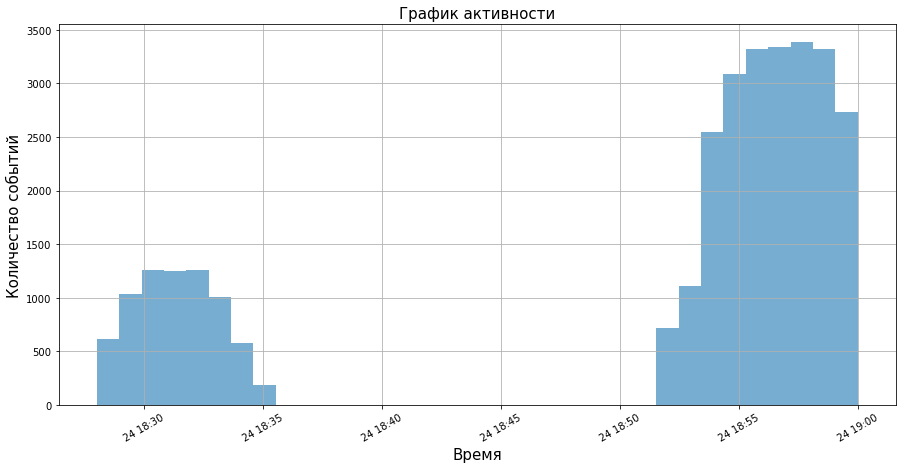

In [9]:
plt.figure(figsize=(15,7))
dash_visits['dt'].hist(bins=34, xrot=15, alpha=0.6)
plt.title('График активности', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.xlabel('Время', fontsize=15)
plt.xticks(rotation=30)
plt.show()

* Периоды: **18:28-18:35** и **18:52-19:00**
* Максимальная активность: **18:58:00**

**Экспортируем данные в csv-файл**

In [10]:
dash_visits.to_csv('dash_visits.csv', index=False)

# Материалы

[Дашборд](https://public.tableau.com/views/Yandex_Dzen_16813423431580/_?:language=en-US&:display_count=n&:origin=viz_share_link)

[Презентация](https://disk.yandex.ru/d/wu05sNhm230DRA)